In [1]:
!nvidia-smi
!python --version
!pip --version

Mon Jul  1 14:42:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58                 Driver Version: 555.58         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P3             15W /   50W |      11MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip list

Package                   Version
------------------------- --------------
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.15.0
beautifulsoup4            4.12.3
bleach                    6.1.0
Brotli                    1.0.9
certifi                   2024.6.2
cffi                      1.16.0
charset-normalizer        2.0.4
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.2
decorator                 5.1.1
defusedxml                0.7.1
exceptiongroup            1.2.1
executing                 2.0.1
fastjsonschema            2.20.0
filelock                  3.13.1
fonttools                 4.53.0
fqdn                      1.5.1
gmpy2                     2.1.2
h11                       0.14.0
httpcore       

## Documentation Links :

> - [How FasterRCNN works and step-by-step PyTorch implementation](https://youtu.be/4yOcsWg-7g8)
> - [Detecting Coconut Trees from the Air in the South Pacific (Tonga)](https://github.com/daveluo/coconuts.git)
> - [Guide to build Faster RCNN in PyTorch](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)

In [3]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import cv2

In [6]:
# Checking the GPU availability
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 4050 Laptop GPU


(224, 224, 3)


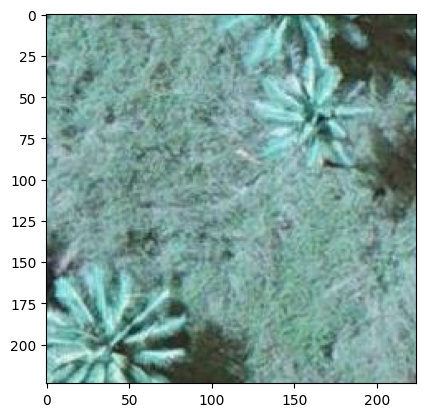

In [7]:
# Reading a sample image
img0 = cv2.imread("../data/raw_data/000000.jpg")
print(img0.shape)
plt.imshow(img0)
plt.show()

(224, 224, 3)


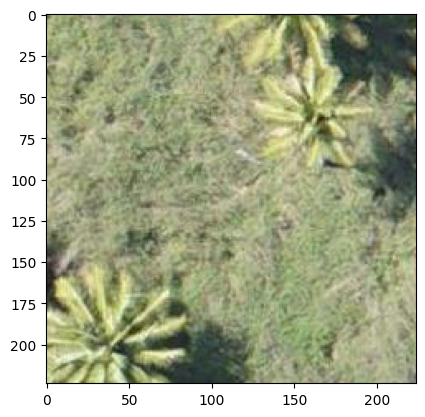

In [8]:
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [9]:
# pre-processiong the annotation
df_bb = pd.read_csv("../data/bb.csv")
df_cats = pd.read_csv("../data/cats.csv")
print(df_bb.head())
print()
print(df_cats.head())

           fn                                     bbox
0  000000.jpg                 0 97 53 187 168 0 224 72
1  000001.jpg                           54 166 144 224
2  000002.jpg           156 141 224 224 15 168 105 224
3  000003.jpg             120 59 210 149 19 90 109 180
4  000004.jpg  81 121 171 211 165 67 224 157 7 0 97 77

           fn                                    clas
0  000000.jpg               coconut_tree coconut_tree
1  000001.jpg                            coconut_tree
2  000002.jpg               coconut_tree coconut_tree
3  000003.jpg               coconut_tree coconut_tree
4  000004.jpg  coconut_tree coconut_tree coconut_tree


In [10]:
# Restructuring the Data-Frames

# Function to process bounding boxes
def process_bboxes(row):
    filename = row['fn']
    bboxes = row['bbox'].split()
    n = len(bboxes) // 4
    
    data = []
    for i in range(n):
        ymin, xmin, ymax, xmax = bboxes[4*i:4*i+4]
        data.append([filename, int(xmin), int(ymin), int(xmax), int(ymax)])
    
    return data

data_bb = []
for _, row in df_bb.iterrows():
    data_bb.extend(process_bboxes(row))

df_bb_processed = pd.DataFrame(data_bb, columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax'])
print(df_bb_processed.head())

print("-"*37)

# Function to process classes
def process_classes(row):
    filename = row['fn']
    classes = row['clas'].split()
    
    data = []
    for clas in classes:
        data.append([filename, clas])
    
    return data

data_class = []
for _, row in df_cats.iterrows():
    data_class.extend(process_classes(row))

df_cats_processed = pd.DataFrame(data_class, columns=['filename', 'class'])
print(df_cats_processed.head())

     filename  xmin  ymin  xmax  ymax
0  000000.jpg    97     0   187    53
1  000000.jpg     0   168    72   224
2  000001.jpg   166    54   224   144
3  000002.jpg   141   156   224   224
4  000002.jpg   168    15   224   105
-------------------------------------
     filename         class
0  000000.jpg  coconut_tree
1  000000.jpg  coconut_tree
2  000001.jpg  coconut_tree
3  000002.jpg  coconut_tree
4  000002.jpg  coconut_tree


In [15]:
# Merging the cats and bb data
df_annotate_data = df_bb_processed.copy()
df_annotate_data['class'] = None


class_index = 0
for idx, row in df_annotate_data.iterrows():
    if class_index < len(df_cats_processed) and row['filename'] == df_cats_processed.iloc[class_index]['filename']:
        df_annotate_data.at[idx, 'class'] = df_cats_processed.iloc[class_index]['class']
        class_index += 1

df_annotate_data.head()

,filename,xmin,ymin,xmax,ymax,class
0,000000.jpg,97,0,187,53,coconut_tree
1,000000.jpg,0,168,72,224,coconut_tree
2,000001.jpg,166,54,224,144,coconut_tree
3,000002.jpg,141,156,224,224,coconut_tree
4,000002.jpg,168,15,224,105,coconut_tree


In [16]:
# Writing the Annotation data to a CSV
df_annotate_data.to_csv("../data/annotation_data.csv", index=False)

In [17]:
data_label = {
    0: "background",
    1: "coconut_tree"
}

In [18]:
# Loading the Annotation data
df = pd.read_csv("../data/annotation_data.csv")
df.head()

,filename,xmin,ymin,xmax,ymax,class
0,000000.jpg,97,0,187,53,coconut_tree
1,000000.jpg,0,168,72,224,coconut_tree
2,000001.jpg,166,54,224,144,coconut_tree
3,000002.jpg,141,156,224,224,coconut_tree
4,000002.jpg,168,15,224,105,coconut_tree


(141, 156, 224, 224)
(168, 15, 224, 105)


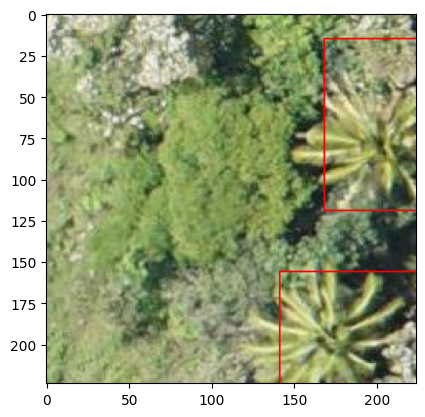

In [33]:
# Loading a sample image to verify the annotation

# for i in df_cats['fn']:    
sample_filename = "000002.jpg"

img = cv2.imread(f"../data/raw_data/{sample_filename}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()

# Object information
image_data = df[df['filename'] == sample_filename]
# print(df[df['filename'] == sample_filename])
xmin = image_data['xmin'].values
ymin = image_data['ymin'].values
xmax = image_data['xmax'].values
ymax = image_data['ymax'].values
classes = image_data['class'].values
# print(xmin, ymin, xmax, ymax, classes)

bbox = np.array([xmin, ymin, xmax, ymax]).T
labels = np.array([label for cls in classes for label in data_label if data_label[label] == cls])

# print(labels)
# print(bbox)
# print(bbox.T)

# display bounding boxes and labels
img_clone = np.copy(img)
# print(len(img_clone))
for i in range(len(bbox)):
    bb_data = (bbox[i][0], bbox[i][1], bbox[i][2], bbox[i][3])
    print(bb_data)
    cv2.rectangle(img_clone, bb_data, color=(255,0,0))
plt.imshow(img_clone)
plt.show()

In [ ]:
class CoconutTreeDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Group annotations by filename
        self.image_annotations = self.annotations.groupby('filename')

    def __len__(self):
        return len(self.image_annotations)

    def __getitem__(self, idx):
        # Get image filename
        img_name = list(self.image_annotations.groups.keys())[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get bounding boxes and labels
        annotations = self.image_annotations.get_group(img_name)
        boxes = annotations[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = boxes.astype(np.float32)
        labels = annotations['class'].apply(self.class_to_label).values

        # Convert to dictionary format
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, target

    def class_to_label(self, class_name):
        # Define mapping from class names to labels (adjust as needed)
        class_map = {
            'coconut_tree': 1
            # Add more class mappings if needed
        }
        return class_map[class_name]


# Transformer Pipelines
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the expected input size of the model
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)  # Color jitter
])


dataset = CoconutTreeDataset(csv_file='../data/annotation_data.csv', img_dir='../data/raw_data/', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))